In [28]:
import sys
import os
import pandas as pd
from pathlib import Path
import cv2

import numpy as np
import skimage.io as io
import matplotlib.pyplot as plt
import torch
from torchvision.models.detection import maskrcnn_resnet50_fpn
import albumentations as A
from albumentations.pytorch import ToTensorV2
from skimage.color import gray2rgb
from torchvision.ops import nms
from pytorch_toolbelt.utils import to_numpy
from dotenv import load_dotenv
from torchvision.utils import draw_segmentation_masks

from src.visualization import tensor_to_image
from src.utils import annotation2mask


current_dir = Path(".")
load_dotenv()
current_dir.absolute()

PosixPath('/home/maxim/sartorius_instance_segmentation')

In [2]:
# Global config of configuration
test_images_dir = Path(os.environ['dataset_path']) / "val"
weights_dir = current_dir / "weights" / "inference.ckpt"
device = "cpu"

In [3]:
# Local tunable parameters of evaluation
score_threshold = 0.0  # All predictions would be counted, even with low score
nms_threshold = 0.2  # Overlapping instances will be dropped, lower - lower overlap is permitted
mask_threshold = 0.5  # Cut masks by the threshold

In [4]:
assert test_images_dir.is_dir(), f"Check test dir path for correctness, was looking at {test_images_dir.absolute()}"
assert weights_dir.is_file(), f"File not found, was looking at {weights_dir.absolute()}"

In [5]:
preprocess_image = A.Compose([
    A.Normalize(mean=(0.485,), std=(0.229,)),
    ToTensorV2(),
])

In [6]:
model = maskrcnn_resnet50_fpn(progress=False, num_classes=4)
model.load_state_dict(torch.load(weights_dir, map_location=torch.device("cpu")))
model.to(device)
model = model.eval()

In [7]:
image_paths = list(test_images_dir.glob("**/*.png"))

In [8]:
def load_image(image_path: str):
    image = io.imread(str(image_path))
    return image

In [9]:
def get_masks_from_image(image):
    image = preprocess_image(image=image)['image']
    image = image.to(device)
    
    with torch.no_grad():
        output = model.forward([image])[0]

    scores = output['scores'].detach().cpu()
    masks = output['masks'].squeeze().detach().cpu()
    boxes = output['boxes'].detach().cpu()

    print(f"found {len(boxes)} instances!")

    masks = (masks >= mask_threshold).int()

    # Now some masks can be empty (all zeros), we need to exclude them
    indices = torch.as_tensor([torch.sum(mask) > 0 for mask in masks])
    masks, boxes, scores = masks[indices], boxes[indices], scores[indices]

    print(f"After mask thresholding survived {len(masks)} instances")

    indices = scores >= score_threshold
    masks, boxes, scores = masks[indices], boxes[indices], scores

    print(f"After confidence thresholding survived {len(masks)} instances")

    indices = nms(boxes, scores, nms_threshold)
    masks, boxes, scores = masks[indices], boxes[indices], scores[indices]

    print(f"Finally, after NMS survived {len(masks)} instances!") 
    return masks

In [19]:
def to_rgb_image(im: torch.Tensor):
    return np.transpose(im.numpy(), axes=(1, 2, 0))


def draw_segmentation_mask(image, masks):
    gt_image = gray2rgb(image.squeeze())
    gt_image = torch.as_tensor(np.transpose(gt_image, axes=(2, 0, 1)), dtype=torch.uint8)
    gt_masks = torch.as_tensor(masks == 1)

    segm = draw_segmentation_masks(
        image=gt_image,
        masks=gt_masks,
        alpha=0.5
    )
    return to_rgb_image(segm)

# Run inference on validation images

In [20]:
def load_true_masks(image_path: Path):
    data_csv = pd.read_csv(test_images_dir / "test.csv")
    data_csv = data_csv.groupby(['id', 'cell_type'])['annotation'].agg(lambda x: list(x)).reset_index()
    annotations = data_csv[data_csv.id == image_path.stem].annotation.item()
    masks = np.array(list(map(lambda line: annotation2mask(line), annotations)))
    return torch.tensor(masks)

In [35]:
save_path = Path("figures") / "mask_r_cnn_mask_prediction"
save_path.mkdir(parents=True, exist_ok=True)

for image_path in image_paths:
    image = load_image(image_path)
    predicted_masks = get_masks_from_image(image)
    image_with_mask = draw_segmentation_mask(image, predicted_masks)
    cv2.imwrite(str(save_path/image_path.name), image_with_mask)

found 86 instances!
After mask thresholding survived 86 instances
After confidence thresholding survived 86 instances
Finally, after NMS survived 50 instances!
found 85 instances!
After mask thresholding survived 85 instances
After confidence thresholding survived 85 instances
Finally, after NMS survived 80 instances!
found 30 instances!
After mask thresholding survived 30 instances
After confidence thresholding survived 30 instances
Finally, after NMS survived 30 instances!
found 29 instances!
After mask thresholding survived 29 instances
After confidence thresholding survived 29 instances
Finally, after NMS survived 24 instances!
found 39 instances!
After mask thresholding survived 39 instances
After confidence thresholding survived 39 instances
Finally, after NMS survived 25 instances!
found 100 instances!
After mask thresholding survived 100 instances
After confidence thresholding survived 100 instances
Finally, after NMS survived 100 instances!
found 26 instances!
After mask thres

# Visualize model predictions, online

In [38]:
def visualize_results(pred_segm, true_segm):    
    fig, axes = plt.subplots(ncols=2, figsize=(16, 8))
    axes[0].imshow(pred_segm)
    axes[0].set_title("Predicted masks")
    axes[1].imshow(true_segm)
    axes[1].set_title("True masks")
    for ax in axes:
        ax.set_xticks([])
        ax.set_yticks([])
    plt.tight_layout(pad=0.1, h_pad=0.1, w_pad=0.1)
    plt.show()

found 86 instances!
After mask thresholding survived 86 instances
After confidence thresholding survived 86 instances
Finally, after NMS survived 50 instances!


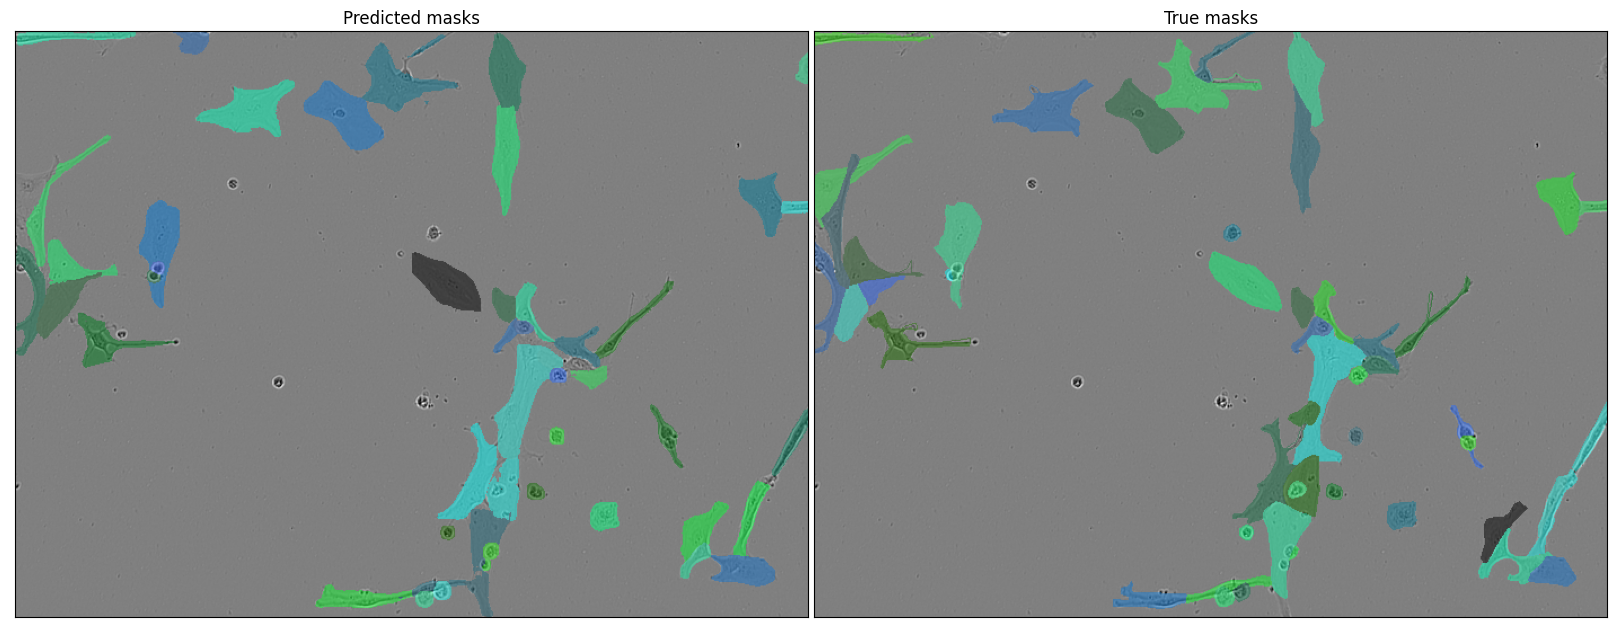

In [39]:
image_path = image_paths[0]

image = load_image(image_path)
predicted_masks = get_masks_from_image(image)
true_masks = load_true_masks(image_path)
predicted_image = draw_segmentation_mask(image, predicted_masks)
true_image = draw_segmentation_mask(image, true_masks)
visualize_results(predicted_image, true_image)